<a href="https://colab.research.google.com/github/chahn85/Groq_LLAMA3.1_RAG/blob/main/GraphRAG_MayoLT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install langchain langchain-community langchain-experimental langchain-groq langgraph chromadb sentence-transformers networkx matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107

In [ ]:
pip install pypdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.8/295.8 kB 18.7 MB/s eta 0:00:00


In [ ]:
import os
from langchain_community.document_loaders import DirectoryLoader, PyPDFLoader
from langchain_text_splitters import CharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_groq import ChatGroq
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langgraph.graph import StateGraph, END
from typing import Dict, TypedDict, List, Optional
import networkx as nx
import matplotlib.pyplot as plt
import re

In [ ]:
# Set up environment variables
os.environ["GROQ_API_KEY"] = '

In [ ]:
# Load documents
loader = DirectoryLoader('/content/drive/MyDrive/Mayo_LT', glob="**/*.pdf", loader_cls=PyPDFLoader)
documents = loader.load()


In [ ]:
# Split text into chunks
text_splitter = CharacterTextSplitter(chunk_size=2000, chunk_overlap=400)
texts = text_splitter.split_documents(documents)

In [ ]:
# Create embeddings
embeddings = HuggingFaceEmbeddings()


/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:141: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 0.3.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  warn_deprecated(
/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [ ]:
# Create vector store
persist_directory = "liver_transplant_db"
vectordb = Chroma.from_documents(documents=texts, embedding=embeddings, persist_directory=persist_directory)
retriever = vectordb.as_retriever()



In [ ]:
# Set up LLM
llm = ChatGroq(model="llama-3.1-70b-versatile", temperature=0)


In [ ]:
# Create a simple graph from the documents
G = nx.Graph()

def extract_entities(text):
    # This is a very basic entity extraction. In a real-world scenario, you'd use a more sophisticated NER model.
    entities = re.findall(r'\b([A-Z][a-z]+(?:\s+[A-Z][a-z]+)*)\b', text)
    return list(set(entities))

for i, doc in enumerate(texts):
    entities = extract_entities(doc.page_content)
    for entity in entities:
        if not G.has_node(entity):
            G.add_node(entity, document_ids=[i])
        else:
            G.nodes[entity]['document_ids'].append(i)

    for e1 in entities:
        for e2 in entities:
            if e1 != e2:
                if G.has_edge(e1, e2):
                    G[e1][e2]['weight'] += 1
                else:
                    G.add_edge(e1, e2, weight=1)


In [ ]:
# Define custom prompt template
custom_prompt_template = """
You are an expert liver transplant coordinator with access to Mayo Clinic's guidelines and policies on liver transplantation. Answer the following question comprehensively and with precision based on the provided context and graph information. Provide detailed explanations and, when applicable, include numerical criteria and eligibility thresholds. Always cite the specific guideline or policy you're referencing.

Query: {question}

Context: {context}

Graph Information: {graph_info}

Please structure your response as follows:
1. Comprehensive answer to the query (provide a detailed explanation, including background information if relevant)
2. Key points or criteria (always include numerical data if applicable, but don't force it if not relevant)
3. Relevant guidelines or policies (mention specific documents and provide brief summaries of their content)
4. Additional considerations or implications

Ensure your response is tailored to the specific query. Not all sections may be necessary for every question - use your judgment to provide the most relevant and helpful information.

After formulating your response, please review it for accuracy, especially regarding any numerical data or specific guidelines mentioned.
"""

PROMPT = PromptTemplate(template=custom_prompt_template, input_variables=["context", "question", "graph_info"])


In [ ]:
# Define GraphState
class GraphState(TypedDict):
    question: Optional[str]
    context: Optional[str]
    graph_info: Optional[str]
    response: Optional[str]


In [ ]:

# Define graph functions
def retrieve_context(state: GraphState) -> Dict:
    question = state["question"]
    docs = retriever.get_relevant_documents(question)
    context = "\n".join([doc.page_content for doc in docs])
    return {"context": context}

def query_graph(state: GraphState) -> Dict:
    question = state["question"]
    entities = extract_entities(question)
    relevant_nodes = set()
    for entity in entities:
        if G.has_node(entity):
            relevant_nodes.add(entity)
            relevant_nodes.update(G.neighbors(entity))

    subgraph = G.subgraph(relevant_nodes)
    graph_info = f"Relevant entities: {', '.join(relevant_nodes)}\n"
    graph_info += "Relationships:\n"
    for edge in subgraph.edges(data=True):
        graph_info += f"{edge[0]} -- {edge[2]['weight']} -- {edge[1]}\n"

    return {"graph_info": graph_info}

def generate_response(state: GraphState) -> Dict:
    question = state["question"]
    context = state["context"]
    graph_info = state["graph_info"]

    response = llm.invoke(PROMPT.format(question=question, context=context, graph_info=graph_info))
    return {"response": response.content}


In [ ]:
# ... (previous code remains the same)

# Create StateGraph
workflow = StateGraph(GraphState)

# Add nodes
workflow.add_node("retrieve_context", retrieve_context)
workflow.add_node("query_graph", query_graph)
workflow.add_node("generate_response", generate_response)

# Set the entry point
workflow.set_entry_point("retrieve_context")

# Add edges
workflow.add_edge("retrieve_context", "query_graph")
workflow.add_edge("query_graph", "generate_response")
workflow.add_edge("generate_response", END)

# Compile graph
app = workflow.compile()

# ... (rest of the code remains the same)

In [ ]:
# Function to run the graph and get response
def get_response(question: str) -> str:
    result = app.invoke({"question": question})
    return result["response"]


In [ ]:

# Example usage
question = "What is the liver transplant eligibility criteria for intrahepatic cholangiocarcinoma at Mayo Clinic?"
response = get_response(question)
print(response)


**Comprehensive answer to the query:**

The liver transplant eligibility criteria for intrahepatic cholangiocarcinoma (iCCA) at Mayo Clinic are outlined in the "Liver Transplant for Patients with Intrahepatic Cholangiocarcinoma (iCCA) Guideline" and the "Management of Intrahepatic Cholangiocarcinoma (iCCA) in Liver Transplant Candidates and Recipients Guideline." These guidelines provide a framework for evaluating and managing patients with iCCA who are being considered for liver transplantation.

**Key points or criteria:**

1. **Single lesion size:** The mass should be less than or equal to 3 cm in the radial diameter.
2. **No vascular invasion:** Vascular invasion is a contraindication for a transplant, but vascular encasement is not an exclusion criterion.
3. **No extrahepatic disease:** Patients should have no evidence of extrahepatic disease, including positive nodes.
4. **No prior resection with tumor plane violation:** Patients should not have attempted prior resection with vio

In [ ]:

# Example usage
question = "My patient has portopulmonary hypertension with mean PA pressure of 50mmHg. Is he eligible for MELD exception?"
response = get_response(question)
print(response)


**Comprehensive Answer**

The patient in question has portopulmonary hypertension (POPH) with a mean pulmonary arterial pressure (MPAP) of 50mmHg. To determine if the patient is eligible for a Model for End-Stage Liver Disease (MELD) exception, we need to consider the requirements outlined in the OPTN Policy 9.5.G.

According to the policy, a candidate will receive a MELD score exception for POPH if the transplant program submits evidence of the following:

1. Initial mean pulmonary arterial pressure (MPAP) level ≥ 35 mmHg and initial pulmonary vascular resistance (PVR) level ≥ 240 dynes*sec/cm5 (or ≥ 3 Wood units [WU]) via heart catheterization.
2. Other causes of pulmonary hypertension have been assessed and determined to not be a significant contributing factor.
3. Initial transpulmonary gradient to correct for volume overload.
4. Documentation of treatment.
5. Post-treatment MPAP < 35 mmHg and post-treatment PVR < 400 dynes*sec/cm5 (or < 5 Wood units [WU]) via heart catheterization

In [ ]:

# Example usage
question = "My patient is CMV mismatch with D+/R-. Does she need CMV prophylaxis post transplant?"
response = get_response(question)
print(response)


**Comprehensive Answer**

The patient in question has a CMV mismatch with a donor (D+) and recipient (R-) status. According to the provided guidelines, a CMV D+/R- mismatch is considered high-risk for CMV infection. As a result, CMV prophylaxis is recommended for this patient.

The guidelines suggest that for patients with a CMV D+/R- mismatch, Valganciclovir prophylaxis should be administered orally daily for at least 4 weeks after liver transplantation. Additionally, CMV DNA monitoring may be required on a case-by-case basis, and consultation with the Pediatric Infectious Diseases service is recommended.

**Key Points or Criteria**

* CMV D+/R- mismatch is considered high-risk for CMV infection
* Valganciclovir prophylaxis is recommended for at least 4 weeks after liver transplantation
* CMV DNA monitoring may be required on a case-by-case basis
* Consultation with the Pediatric Infectious Diseases service is recommended

**Relevant Guidelines or Policies**

* The guidelines provided

In [ ]:

# Example usage
question = "Outline a detailed week-by-week dietary plan for an obese patient who underwent gastric sleeve at the time of liver transplant."
response = get_response(question)
print(response)


**Comprehensive Answer**

For an obese patient who underwent gastric sleeve at the time of liver transplant, a detailed week-by-week dietary plan is crucial to ensure proper nutrition, weight management, and overall health. According to the Mayo Clinic's Liver Post-Transplant Obesity and Bariatric Surgery Guideline, patients who have undergone bariatric surgery prior to or in combination with liver transplant require close monitoring and guidance on their dietary habits.

The first few weeks after surgery are critical, and the patient's diet should be tailored to meet their nutritional needs while minimizing complications. The goal is to achieve a calorie-restricted diet with adequate protein intake. A typical calorie restriction for post-transplant patients is 1,000-1,200 calories per day, with a protein intake of 60-80 grams per day.

Here is a sample week-by-week dietary plan for the first 12 weeks after surgery:

Weeks 1-2:

* Liquid diet with a caloric intake of 500-600 calories p

In [ ]:

# Example usage
question = "A 30 year old female underwent liver transplantation. What is the guideline for bone mineral density testing for her?"
response = get_response(question)
print(response)


**Comprehensive Answer:**

The query asks about the guideline for bone mineral density (BMD) testing for a 30-year-old female who underwent liver transplantation. According to the Liver Osteoporosis Guideline - Arizona, Florida, Rochester, BMD testing is recommended for liver transplant recipients based on their age and risk factors.

Since the patient is under 40 years old, the guideline recommends BMD testing at year 1, 2, and every 5 years after transplant if she has no risk factors. However, if she has risk factors such as a history of osteoporotic fracture, Z-score < -2 at hip or spine, significant loss of BMD at hip or spine, or is on osteoporosis therapy, BMD testing is recommended at year 1, 2, and every 3 years after transplant.

**Key Points or Criteria:**

* Age < 40 with no risk factors: BMD testing at year 1, 2, and every 5 years after transplant
* Age < 40 with risk factors: BMD testing at year 1, 2, and every 3 years after transplant
* Risk factors include:
	+ History of

In [ ]:
# Example usage
question = "A 40 year old patient had AKI secondary to hepatorenal syndrome and ended up on dialysis. He has not regained urine output and remains on dialysis for the past 2 weeks. Is he eligible for simultaneous liver and kidney transplantation? Please provide the specific eligibility criteria for SLK"
response = get_response(question)
print(response)


**Comprehensive Answer**

The patient in question has developed acute kidney injury (AKI) secondary to hepatorenal syndrome and has been on dialysis for the past 2 weeks. Given the patient's liver disease and subsequent kidney failure, the question arises whether they are eligible for simultaneous liver and kidney transplantation (SLK).

According to the provided guidelines, renal dysfunction does not exclude a patient from candidacy for liver transplantation. However, the decision to proceed with SLK is made on an individual basis. The patient's condition, including the severity of their liver disease and kidney failure, will be assessed by the transplant team to determine the best course of action.

**Key Points or Criteria**

* The patient must have a life expectancy without a liver transplant of less than 7 days and meet specific conditions, such as fulminant liver failure, anhepatic, or primary non-function of a transplanted liver within 7 days of transplant (Liver Transplant Stat

In [ ]:
# Example usage
question = "What is the Mayo Clinic's recommendation for first and second-line choices for managing hypertension after liver transplant?"
response = get_response(question)
print(response)


**Comprehensive answer to the query:**

The Mayo Clinic's recommendation for managing hypertension after liver transplant involves a stepwise approach, starting with lifestyle modifications and progressing to pharmacologic interventions as needed. According to the Liver Transplant Hypertension Treatment Guideline, the first-line pharmacologic option for managing hypertension in liver transplant patients is a calcium channel blocker, specifically a dihydropyridine class agent such as amlodipine or nifedipine. However, it is essential to note that nifedipine may increase the concentration of calcineurin inhibitors, such as tacrolimus or cyclosporine, and therefore requires increased trough monitoring.

**Key points or criteria:**

* Blood pressure greater than 140/90 mmHg is considered hypertension in liver transplant patients.
* First-line pharmacologic option: dihydropyridine class calcium channel blocker (e.g., amlodipine or nifedipine).
* Nifedipine may increase calcineurin inhibitor

In [ ]:
question = "My patient's AST spiked to 4000 on day 3 after transplant. Patient is ill with arterial pH of 7.2 and lactate of 5. Ultrasound shows hepatic artery thrombosis. Does he meet the eligibility for Status 1A listing?"
response = get_response(question)
print(response)

RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-70b-versatile` in organization `org_01j0ygagnxekab5mx7w1acywrt` on : Limit 1000000, Used 837312, Requested 309050. Please try again in 3h30m45.628799999s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': '', 'code': 'rate_limit_exceeded'}}

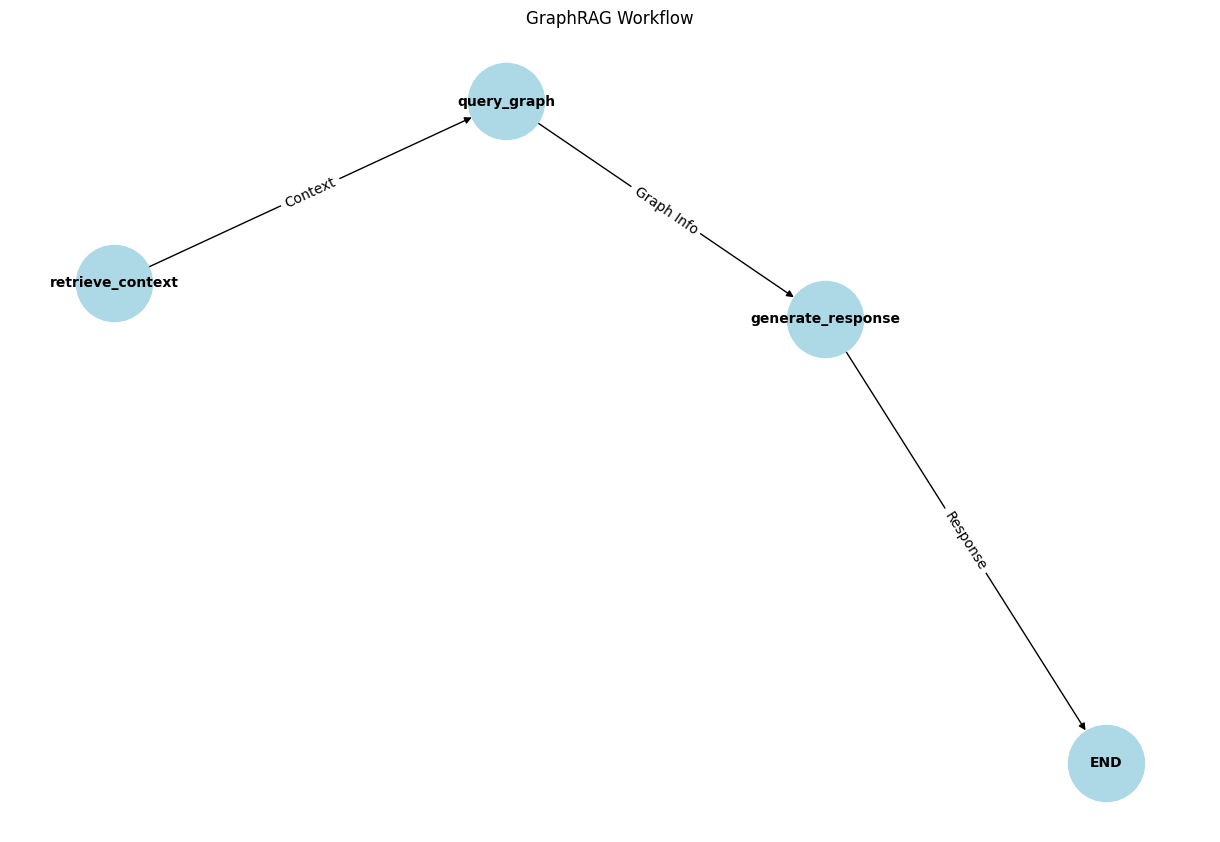

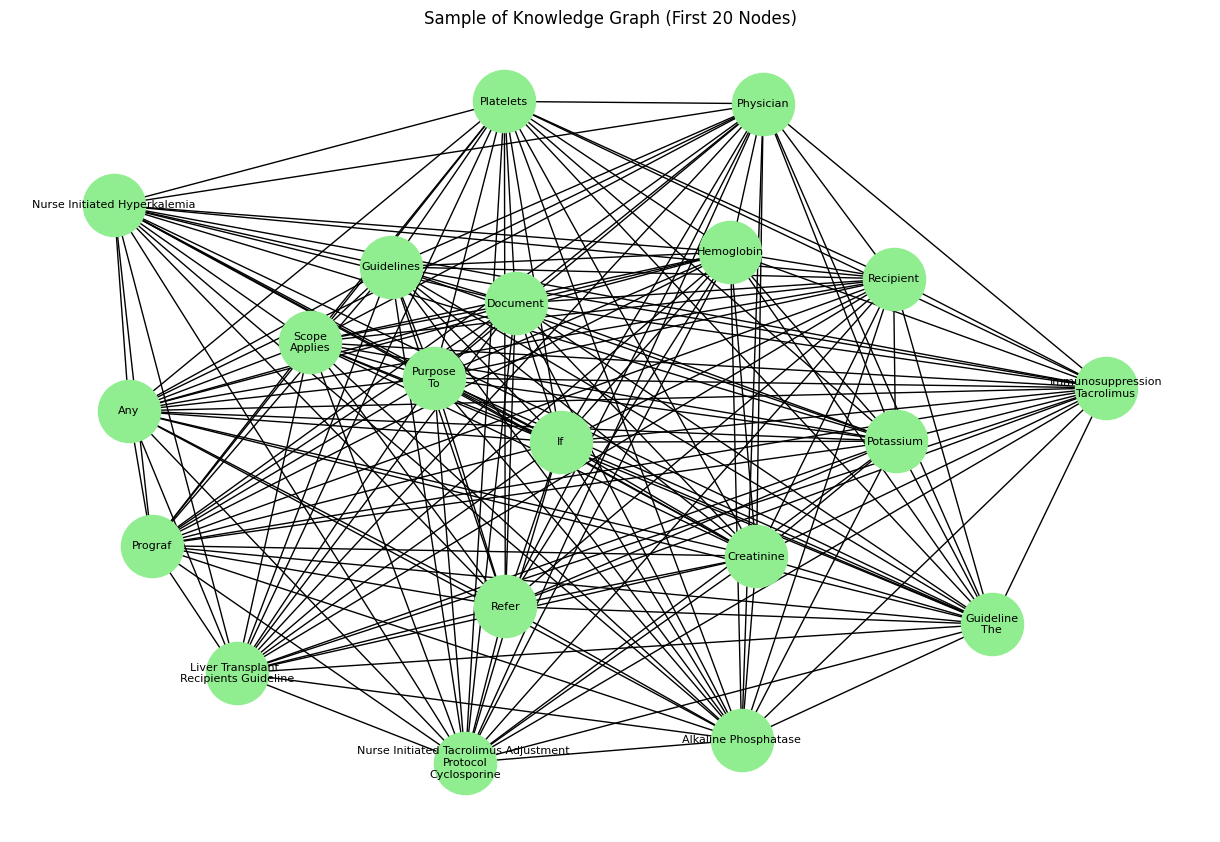

In [ ]:
# Visualize the workflow graph
workflow_graph = nx.DiGraph()
workflow_graph.add_edges_from([
    ("retrieve_context", "query_graph"),
    ("query_graph", "generate_response"),
    ("generate_response", "END")
])

pos = nx.spring_layout(workflow_graph)
plt.figure(figsize=(12, 8))
nx.draw(workflow_graph, pos, with_labels=True, node_color='lightblue', node_size=3000, font_size=10, font_weight='bold')
edge_labels = {("retrieve_context", "query_graph"): "Context",
               ("query_graph", "generate_response"): "Graph Info",
               ("generate_response", "END"): "Response"}
nx.draw_networkx_edge_labels(workflow_graph, pos, edge_labels=edge_labels)
plt.title("GraphRAG Workflow")
plt.axis('off')
plt.show()

# Visualize a portion of the knowledge graph
plt.figure(figsize=(12, 8))
subgraph = G.subgraph(list(G.nodes())[:20])  # Visualize first 20 nodes
pos = nx.spring_layout(subgraph)
nx.draw(subgraph, pos, with_labels=True, node_color='lightgreen', node_size=2000, font_size=8)
plt.title("Sample of Knowledge Graph (First 20 Nodes)")
plt.axis('off')
plt.show()


In [ ]:

# Visualize a portion of the knowledge graph
plt.figure(figsize=(12, 8))
subgraph = G.subgraph(list(G.nodes)[:20])  # Visualize first 20 nodes
pos = nx.spring_layout(subgraph)
nx.draw(subgraph, pos, with_labels=True, node_color='lightgreen', node_size=2000, font_size=8)
plt.title("Sample of Knowledge Graph (First 20 Nodes)")
plt.axis('off')
plt.show()